In [1]:
# Importing the needed modules
# Added Kumar's imports to this section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import matplotlib as mpl


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy import linalg
from sklearn import mixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib import rcParams

warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# To display plots inside the iPython Notebook itself
%matplotlib inline

In [2]:
# To verify how data is orgainzed in file(to find the delimiter) and then
# use corresponding function to open the file. eg
# data could be in .csv. .tsv, excel format etc.
pathOfDataFile = "data/HTRU_2.csv"
firstFewLines = list()
noOfLinesToView = 2

with open(pathOfDataFile) as dataFile:
    firstFewLines = [next(dataFile) for i in range(noOfLinesToView)]
    for line in firstFewLines:
        print(line)

140.5625,55.68378214,-0.234571412,-0.699648398,3.199832776,19.11042633,7.975531794,74.24222492,0

102.5078125,58.88243001,0.465318154,-0.515087909,1.677257525,14.86014572,10.57648674,127.3935796,0



In [3]:
# Import the colon delimited data file into pandas dataFrame
pulsars_Df = pd.read_csv(pathOfDataFile, sep = ",", names= ["mean_intg", "sd_intg", "exc_kurt_intg", "skw_intg", "mean_dmsnr", \
                                      "sd_dmsnr", "exc_kurt_dmsnr", "skw_dmsnr", "class"])

pulsars_Df.head(2)

,mean_intg,sd_intg,exc_kurt_intg,skw_intg,mean_dmsnr,sd_dmsnr,exc_kurt_dmsnr,skw_dmsnr,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0


In [4]:
imputedPulsarDf = pulsars_Df.copy()
imputedPulsarDf['log_mean_dmsnr'] = np.log(imputedPulsarDf['mean_dmsnr'])
imputedPulsarDf['log_sd_dmsnr'] = np.log(imputedPulsarDf['sd_dmsnr'])
imputedPulsarDf.drop(['sd_dmsnr', 'mean_dmsnr'], axis = 1, inplace = True)
imputedPulsarDf.describe()

,mean_intg,sd_intg,exc_kurt_intg,skw_intg,exc_kurt_dmsnr,skw_dmsnr,class,log_mean_dmsnr,log_sd_dmsnr
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,8.303556,104.857709,0.091574,1.390669,3.079164
std,25.652935,6.843189,1.064040,6.167913,4.506092,106.514540,0.288432,1.235812,0.572203
min,5.812500,24.772042,-1.876011,-1.791886,-3.139270,-1.976976,0.000000,-1.545474,1.997476
25%,100.929688,42.376018,0.027098,-0.188572,5.781506,34.960504,0.000000,0.653926,2.669817
50%,115.078125,46.947479,0.223240,0.198710,8.433515,83.064556,0.000000,1.030276,2.915677
75%,127.085938,51.023202,0.473325,0.927783,10.702959,139.309331,0.000000,1.698228,3.347378
max,192.617188,98.778911,8.069522,68.101622,34.539844,1191.000837,1.000000,5.408929,4.706302


In [5]:
# Standardize and Scale the dataset

scaler = StandardScaler()
scaledPulsarData = scaler.fit(imputedPulsarDf.drop("class", axis =1)).transform(imputedPulsarDf.drop("class", axis =1))

In [6]:
# Perform PCA and plot Scree plot

# initially set n_compoments = no of features and later look at variance explained in Scree plot
# To choose number of PCA components 

pca = PCA(n_components=8)
X_pca = pca.fit(scaledPulsarData).transform(scaledPulsarData)
print(scaledPulsarData.shape)
print(X_pca.shape)

(17898, 8)
(17898, 8)


In [7]:
### Seperate the class and predictor variables
X = scaledPulsarData
y = imputedPulsarDf['class'].values

In [8]:
## Since we have class imbalance, create a stratified Shuffle 80/20 split CV object
num_cv_iterations = 10
stratified_cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=999)
                         
print(stratified_cv_object)

StratifiedShuffleSplit(n_splits=10, random_state=999, test_size=0.2,
            train_size=None)


In [9]:
###### Function Taken from Dr. Larsons Notebook ##############################

# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:])
        tmp_array.append(tmp_string)
    return tmp_array
  
# now let's get to the Data Analytics!
pca_weight_strings = get_feature_names_from_weights(pca.components_, imputedPulsarDf.drop("class", axis =1).columns) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])
df_pca["class"] = imputedPulsarDf["class"]


## Objects
- DataFrames
    - pulsars_Df
    - imputedPulsarDf
    - scaledPulsarData

- Class Predictor Variables
    - X = scaledPulsarData
    - y = imputedPulsarDf['class'].values

- CV Object
    - stratified_cv_object

### Gaussian Mixture Model (GMM)

In [26]:
# this code has been manipulated from the source available on sklearn's website documentation
X = scaledPulsarData


lowest_bic = np.infty
bic = []
silhouette = []
GMMRand=[]
n_components_range = range(2,17)
cv_types = ['spherical', 'diag', 'full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components,max_iter = 1000, covariance_type=cv_type)
        gmm.fit(X)
        Y_ = gmm.predict(X)
        bic.append(gmm.bic(X))
        GMMRand.append(adjusted_rand_score( imputedPulsarDf['class'].values, Y_))
        silhouette.append(silhouette_score(X, Y_))
        print("Rand Score: ", adjusted_rand_score( imputedPulsarDf['class'].values, Y_), "Silhouette Score : ", silhouette_score(X, Y_), "Covraince Type :", cv_type, "BIC Value : ", gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


Rand Score:  0.3081181583070962 Silhouette Score :  0.4255840944998196 Covraince Type : spherical BIC Value :  318594.9247089527
Rand Score:  0.25404200949244904 Silhouette Score :  0.33515196370020245 Covraince Type : spherical BIC Value :  295331.3360288784
Rand Score:  0.20985774443620614 Silhouette Score :  0.3477171822677105 Covraince Type : spherical BIC Value :  271052.0183216693
Rand Score:  0.10021772829960737 Silhouette Score :  0.27768767470866174 Covraince Type : spherical BIC Value :  248365.1768543559
Rand Score:  0.10392622839317352 Silhouette Score :  0.2795826892801823 Covraince Type : spherical BIC Value :  241520.2519883046
Rand Score:  0.06322505767962047 Silhouette Score :  0.24734548342367244 Covraince Type : spherical BIC Value :  221737.57119708907
Rand Score:  0.06822861684083613 Silhouette Score :  0.2599387951906488 Covraince Type : spherical BIC Value :  214600.67689471372
Rand Score:  0.05932295474784899 Silhouette Score :  0.23657424795136542 Covraince Typ

Silhouette score, BIC and BIC Gradient are used to choose the covariance method and number of components for GMM.

Silhouette score considers two measures:
**The mean distance between a sample and all other points in the same cluster
**The mean distance between a sample and all other points in the next nearest cluster

Silhouette score checks how cluesters are compact and separate. If the score is higher (closer to 1) then the clustering is better. This score alone is not sufficient in selecting number of components for GMM.

The second measure that we use is Bayesian information criterion (BIC). This gives an estimation of how good GMM is in predicting the actual data. The prediction is better if the BIC value is lower. BIC value alone should not be used as it may lead to overfitting. As the number of clusters increases, BIC value reduces. Instead of using BIC value alone, BIC gradient is also used to select the number of components. 

The hyperparameter covariance_type controls the degrees of freedom in the shape of each cluster; The default is covariance_type="diag", which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. A slightly simpler and faster model is covariance_type="spherical", which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use covariance_type="full", which allows each cluster to be modeled as an ellipse with arbitrary orientation.

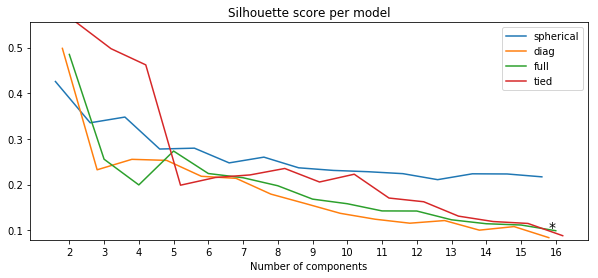

In [27]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the silhouette
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []


plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the silhouette scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    plt.plot(xpos, silhouette[i * len(n_components_range):(i + 1) * len(n_components_range)])
plt.xticks(n_components_range)
plt.ylim([min(silhouette) * 1.01 - .01 * max(silhouette), max(silhouette)])
plt.title('Silhouette score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(np.argmin(silhouette), len(n_components_range)) +\
    .2 * np.floor(np.argmin(silhouette) / len(n_components_range))
plt.text(xpos, min(silhouette) * 0.97 + .03 * max(silhouette), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend(cv_types)

plt.show()

Co-variance 'tied' gave better score than other types. In both cases, number of components were 2. BIC values and gradient BIC are reviewed in the next section to choose the co-variance and number of components.

#### Rand Score 

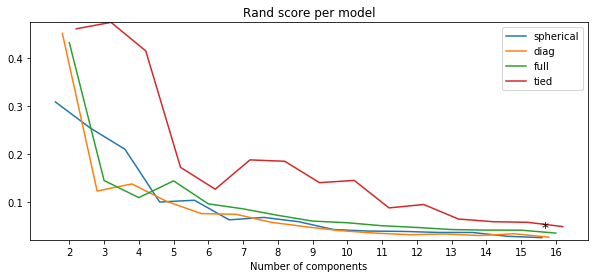

In [28]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the silhouette
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []


plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the silhouette scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    plt.plot(xpos, GMMRand[i * len(n_components_range):(i + 1) * len(n_components_range)])
plt.xticks(n_components_range)
plt.ylim([min(GMMRand) * 1.01 - .01 * max(GMMRand), max(GMMRand)])
plt.title('Rand score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(np.argmin(GMMRand), len(n_components_range)) +\
    .2 * np.floor(np.argmin(GMMRand) / len(n_components_range))
plt.text(xpos, min(GMMRand) * 0.97 + .03 * max(GMMRand), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend(cv_types)

plt.show()

For two clusters, co-variance 'tied' gave slightly better score than 'diag'. For three clusters, co-variance type 'tied' produced the best score.

#### BIC value for all covariance types and number of components

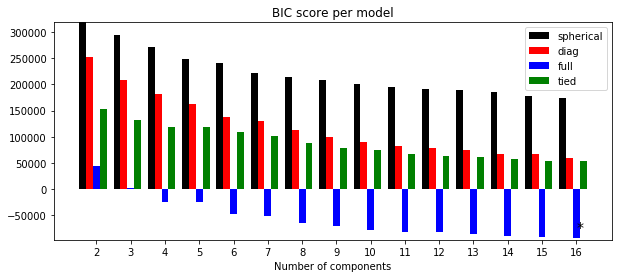

In [29]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

Based on visual examination of BIC values, either 2 or 3 components and co-variance type 'full' are better choice for GMM.

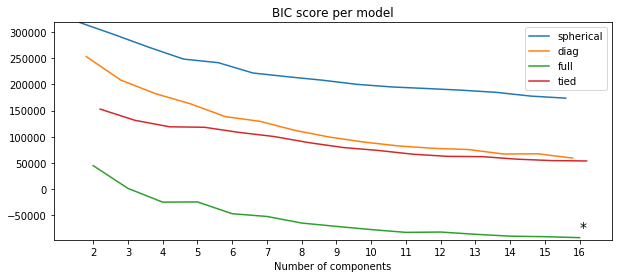

In [30]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    plt.plot(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)])
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend(cv_types)

plt.show()

#### BIC Gradeint for all co-variances and number of components

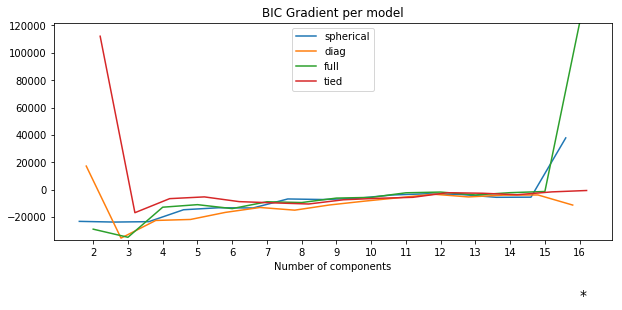

In [31]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
bic_grad = np.gradient(bic)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    plt.plot(xpos, bic_grad[i * len(n_components_range):(i + 1) * len(n_components_range)])
plt.xticks(n_components_range)
plt.ylim([bic_grad.min() * 1.01 - .01 * bic_grad.max(), bic_grad.max()])
plt.title('BIC Gradient per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend(cv_types)

plt.show()

BIC Gradient confirms 2 components and co-variance type 'full' are better suited for GMM for this dataset.

#### Initial Cluster Plots

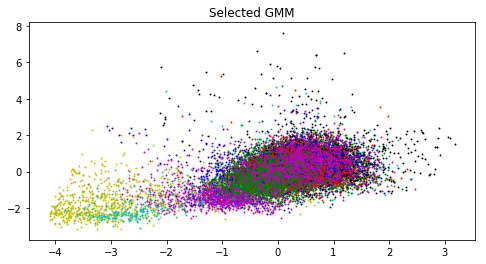

In [32]:
# this code has been manipulated from the source available on sklearn's website documentation
# Plot the winner
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


plt.title('Selected GMM')
plt.show()

The clusters are more as BIC value alone was used in choosing the clusters.

#### Using 'tied' for covariance and reduced range for components

Reduced the co-variance type to 'tied'. Number of clusters to 2 and 3.

In [37]:
# this code has been manipulated from the source available on sklearn's website documentation
X = scaledPulsarData


lowest_bic = np.infty
bic = []
silhouette = []
GMMRand=[]
n_components_range = range(2,4)
cv_types = ['tied']
for cv_type in cv_types:
     for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        Y_ = gmm.predict(X)
        bic.append(gmm.bic(X))
        GMMRand.append(adjusted_rand_score( imputedPulsarDf['class'].values, Y_))
        silhouette.append(silhouette_score(X, Y_))
        print("Number of Clusters :", n_components, "Rand Score: ", adjusted_rand_score( imputedPulsarDf['class'].values, Y_), "Silhouette Score : ", silhouette_score(X, Y_), "Covraince Type :", cv_type)
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


Number of Clusters : 2 Rand Score:  0.46011648314007975 Silhouette Score :  0.5551332307662818 Covraince Type : tied
Number of Clusters : 3 Rand Score:  0.4732224413557381 Silhouette Score :  0.49742520343172175 Covraince Type : tied


#### Plot of Clustering from GMM

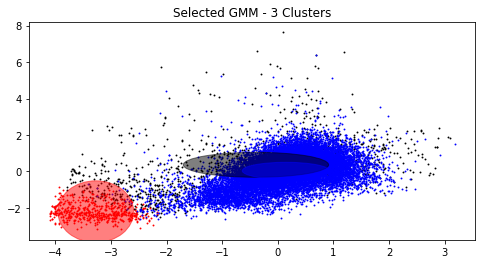

In [40]:
# this code has been manipulated from the source available on sklearn's website documentation
# Plot the winner
clf = best_gmm
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


plt.title('Selected GMM - 3 Clusters')
plt.show()

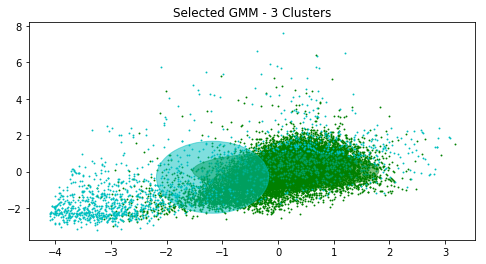

In [42]:
# this code has been manipulated from the source available on sklearn's website documentation
# Plot the winner
clf = mixture.GaussianMixture(n_components=2, covariance_type='tied')
clf.fit(X)
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


plt.title('Selected GMM - 2 Clusters')
plt.show()

#### Silhoutte and Adjusted Rand Score for the final model

In [43]:
n_components = 2
cv_type = 'tied'
gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
gmm.fit(X)
Y_ = gmm.predict(X)

print("Silhouette Score is : ", silhouette_score(X, Y_))
print("Adjusted Rand Score is : ", adjusted_rand_score( imputedPulsarDf['class'].values, Y_) )

Silhouette Score is :  0.664705933079624
Adjusted Rand Score is :  0.4828503787843202


In [45]:
count_true = 0
count_false = 0
count_one = 0
count_zero = 0
count_two = 0

for i in range(0,Y_.shape[0]):
    if Y_[i,] == 0:
        count_zero+=1
    elif Y_[i,] == 1:
        count_one+=1

print("Count of zero :", count_zero)
print("Count of one :", count_one)


for i in range(0,Y_.shape[0]):
    if Y_[i,] == imputedPulsarDf['class'].values[i, ]:
        count_true += 1
    else:
        count_false += 1
print("Correct Prediction Original", count_true)
print("Wrong Prediction Original", count_false)


count_one = 0
count_zero = 0
count_two = 0
for i in range(0,Y_.shape[0]):
    if imputedPulsarDf['class'].values[i, ] == 0:
        count_zero+=1
    elif imputedPulsarDf['class'].values[i, ] == 1:
        count_one+=1
print("Count of zero Ground Truth :", count_zero)
print("Count of one Ground Truth :", count_one)

Count of zero : 17285
Count of one : 613
Correct Prediction Original 16864
Wrong Prediction Original 1034
Count of zero Ground Truth : 16259
Count of one Ground Truth : 1639


### Gaussian Mixture on PCA

In [46]:
silhouette_score_list = []
X = X_pca[: , [0,1,2]]

lowest_bic = np.infty
bic = []
silhouette = []
GMMRand = []
n_components_range = range(2,17)
cv_types = ['spherical', 'diag', 'full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        Y_ = gmm.predict(X)
        bic.append(gmm.bic(X))
        GMMRand.append(adjusted_rand_score( imputedPulsarDf['class'].values, Y_))
        silhouette.append(silhouette_score(X, Y_))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


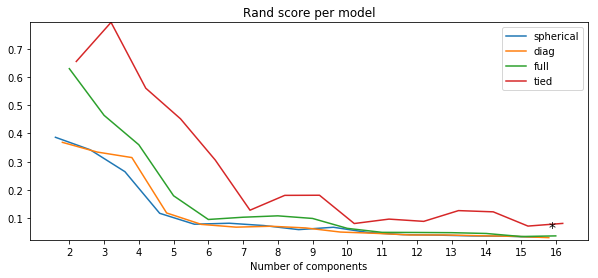

In [47]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the silhouette
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []


plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the silhouette scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    plt.plot(xpos, GMMRand[i * len(n_components_range):(i + 1) * len(n_components_range)])
plt.xticks(n_components_range)
plt.ylim([min(GMMRand) * 1.01 - .01 * max(GMMRand), max(GMMRand)])
plt.title('Rand score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(np.argmin(GMMRand), len(n_components_range)) +\
    .2 * np.floor(np.argmin(GMMRand) / len(n_components_range))
plt.text(xpos, min(GMMRand) * 0.97 + .03 * max(GMMRand), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend(cv_types)

plt.show()

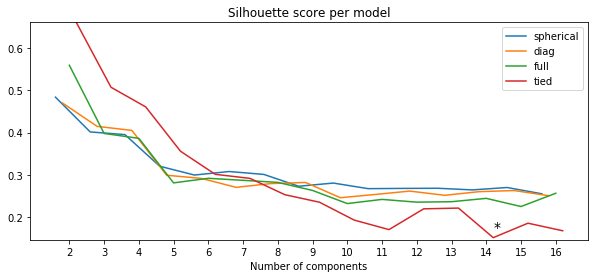

In [48]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the silhouette
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []


plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the silhouette scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    plt.plot(xpos, silhouette[i * len(n_components_range):(i + 1) * len(n_components_range)])
plt.xticks(n_components_range)
plt.ylim([min(silhouette) * 1.01 - .01 * max(silhouette), max(silhouette)])
plt.title('Silhouette score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(np.argmin(silhouette), len(n_components_range)) +\
    .2 * np.floor(np.argmin(silhouette) / len(n_components_range))
plt.text(xpos, min(silhouette) * 0.97 + .03 * max(silhouette), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend(cv_types)

plt.show()

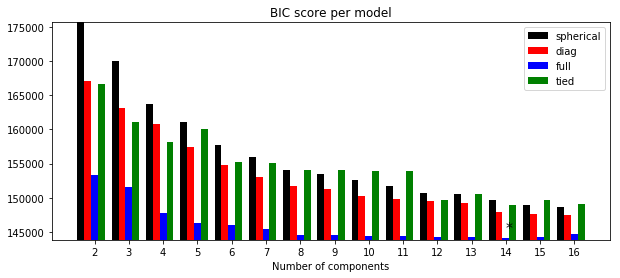

In [49]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

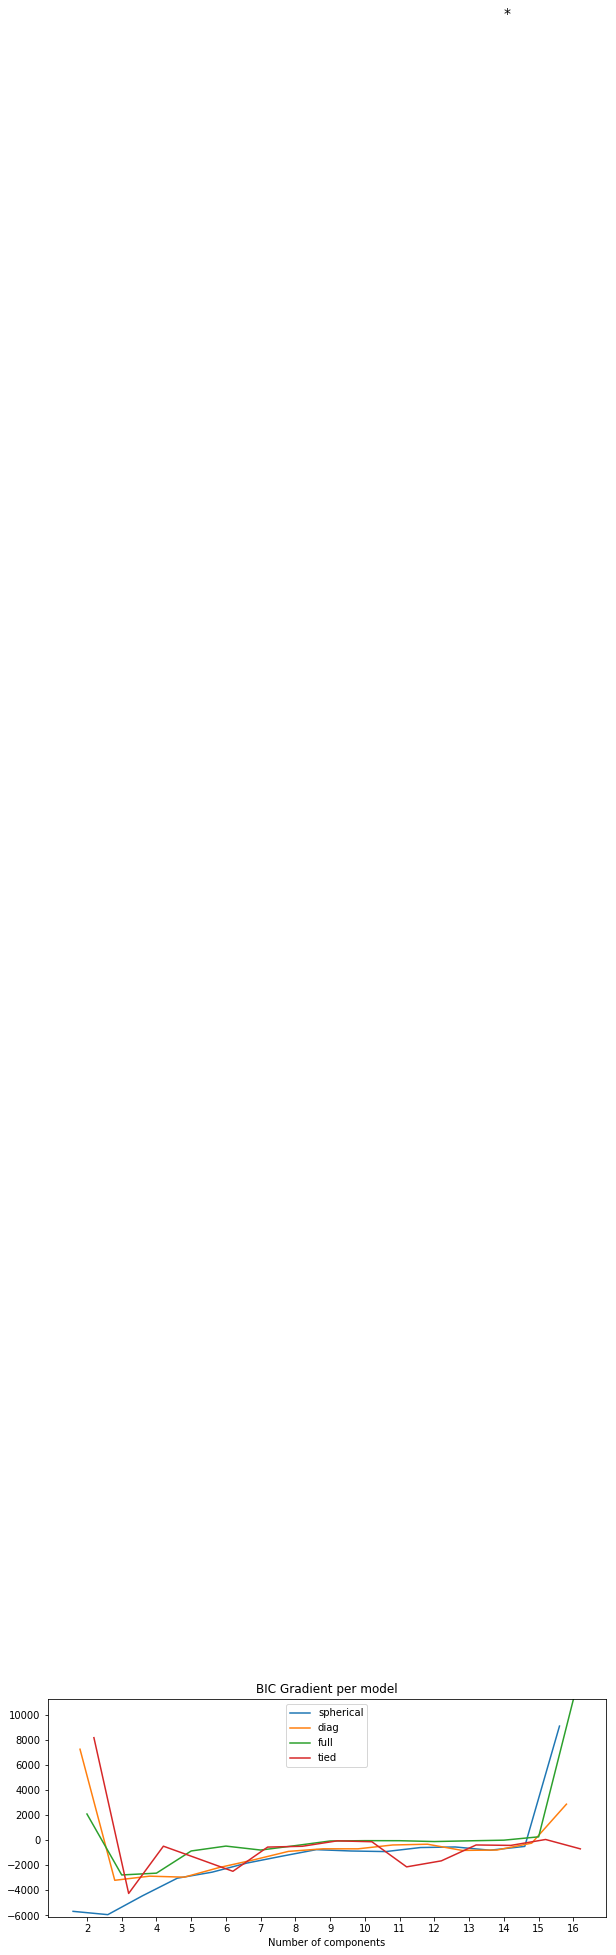

In [50]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
bic_grad = np.gradient(bic)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    plt.plot(xpos, bic_grad[i * len(n_components_range):(i + 1) * len(n_components_range)])
plt.xticks(n_components_range)
plt.ylim([bic_grad.min() * 1.01 - .01 * bic_grad.max(), bic_grad.max()])
plt.title('BIC Gradient per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend(cv_types)

plt.show()

In [51]:
lowest_bic = np.infty
bic = []
silhouette = []
n_components_range = range(2,3)
cv_types = ['full', 'diag', 'tied']
for cv_type in cv_types:
     for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        Y_ = gmm.predict(X)
        bic.append(gmm.bic(X))
        silhouette.append(silhouette_score(X, Y_))
       
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


In [52]:

print("Silhouette Score is : ", silhouette_score(X, Y_))
print("Adjusted Rand Score is : ", adjusted_rand_score( imputedPulsarDf['class'].values, Y_) )

Silhouette Score is :  0.6608465768210425
Adjusted Rand Score is :  0.6549353199706953


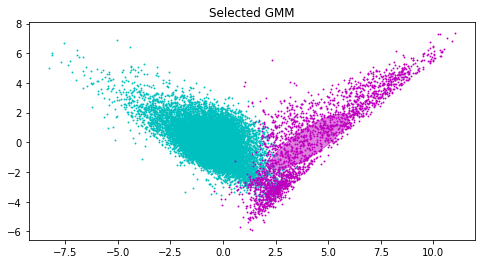

In [53]:
# this code has been manipulated from the source available on sklearn's website documentation
# Plot the winner
clf = best_gmm
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


plt.title('Selected GMM')
plt.show()

In [54]:
count_true = 0
count_false = 0
#Y_reversed = Y_.copy()
#for i in range(0,Y_.shape[0]):
if Y_[i,] == 0:
        Y_reversed[i,] = 1
    elif Y_[i,] == 1:
        Y_reversed[i,] = 0

for i in range(0,Y_.shape[0]):
    if Y_[i,] == imputedPulsarDf['class'].values[i, ]:
        count_true += 1
    else:
        count_false += 1
print("Correct Prediction Original", count_true)
print("Wrong Prediction Original", count_false)

for i in range(0,Y_.shape[0]):
    if Y_reversed[i,] == imputedPulsarDf['class'].values[i, ]:
        count_true += 1
    else:
        count_false += 1
print("Correct Prediction Reversed", count_true)
print("Wrong Prediction Revered", count_false)

IndentationError: unindent does not match any outer indentation level (<ipython-input-54-0da561044da9>, line 7)

In [ ]:
count_true = 0
count_false = 0
count_one = 0
count_zero = 0
count_two = 0

for i in range(0,Y_PCA3GMM.shape[0]):
    if Y_PCA3GMM[i,] == 0:
        count_zero+=1
    elif Y_PCA3GMM[i,] == 1:
        count_one+=1
    elif Y_PCA3GMM[i,] == 2:
        count_two += 1
print("Count of zero :", count_zero)
print("Count of one :", count_one)
print("Count of two:", count_two)

count_one = 0
count_zero = 0
count_two = 0

print('For Two Components:\n')
for i in range(0,Y_PCA3GMM.shape[0]):
    if Y_PCAGMM[i,] == 0:
        count_zero+=1
    elif Y_PCAGMM[i,] == 1:
        count_one+=1
    elif Y_PCAGMM[i,] == 2:
        count_two += 1    
print("Count of zero :", count_zero)
print("Count of one :", count_one)
print("Count of two:", count_two)

for i in range(0,Y_PCAGMM.shape[0]):
    if Y_PCAGMM[i,] == imputedPulsarDf['class'].values[i, ]:
        count_true += 1
    else:
        count_false += 1
print("Correct Prediction Original", count_true)
print("Wrong Prediction Original", count_false)

count_true = 0
count_false = 0
for i in range(0,Y_PCA3GMM.shape[0]):
    if Y_PCA3GMM[i,] == imputedPulsarDf['class'].values[i, ]:
        count_true += 1
    else:
        count_false += 1
print("Correct Prediction 3 comp", count_true)
print("Wrong Prediction 3 comp", count_false)

count_one = 0
count_zero = 0
count_two = 0
for i in range(0,Y_PCAGMM.shape[0]):
    if imputedPulsarDf['class'].values[i, ] == 0:
        count_zero+=1
    elif imputedPulsarDf['class'].values[i, ] == 1:
        count_one+=1
print("Count of zero Ground Truth :", count_zero)
print("Count of one Ground Truth :", count_one)

#### Final Model on PCA

In [55]:
X = X_pca[: , [0, 1,2]]
print(X.shape)

(17898, 3)


In [56]:
n_components = 2
cv_type = 'spherical'
gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, random_state =999)
gmm.fit(X)
Y_PCAGMM = gmm.predict(X)

print("Silhouette Score is : ", silhouette_score(X, Y_))
print("Adjusted Rand Score is : ", adjusted_rand_score( imputedPulsarDf['class'].values, Y_PCAGMM) )

Silhouette Score is :  0.559466792649703
Adjusted Rand Score is :  0.7298040092385717


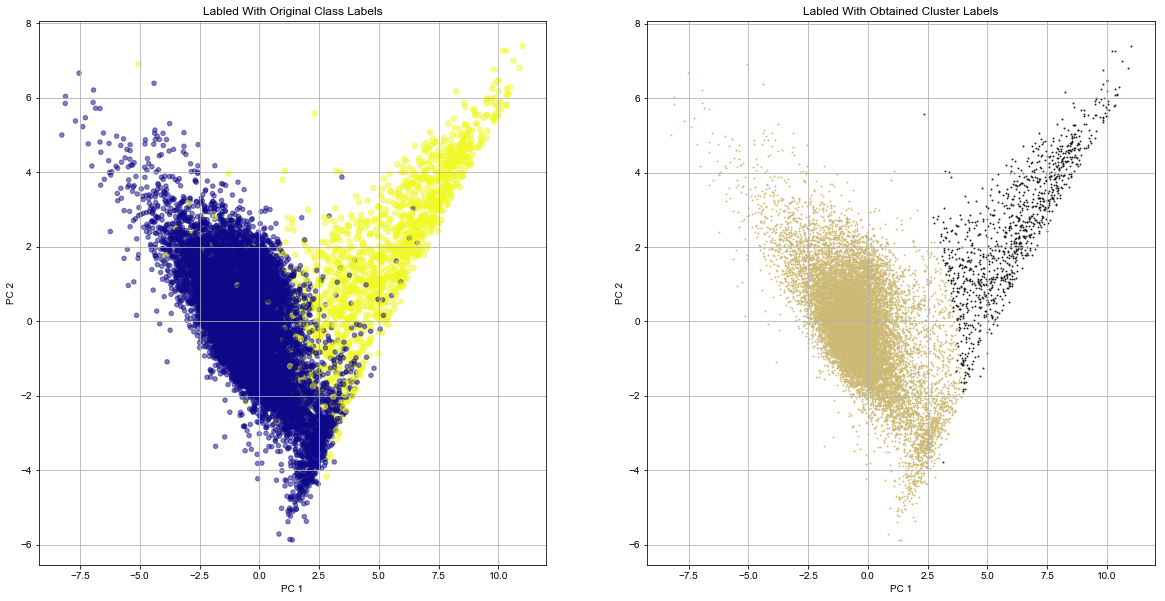

In [57]:
# Plotting 2d Graphs for Initial PCA with class label and PCA after Clustering graphs for visually inspecting
# clustering tendency in the data

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
sns.set(style="white")
ax[0].scatter(x = df_pca[pca_weight_strings[0]], y = df_pca[pca_weight_strings[1]] , \
            c = df_pca["class"], cmap ="plasma", s = (df_pca["class"] + 2)*10, alpha = 0.5)

ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[0].set_title("Labled With Original Class Labels")
ax[0].grid()

#ax[1].scatter(x = Y_PCAGMM[: , 0], y = Y_PCAGMM[: , 1] , \
#            c = (1- n_components) , cmap ="plasma", s = ((1- n_components) + 2)*10, alpha = 0.5))

for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    ax[1].scatter(X[Y_PCAGMM == i, 0], X[Y_PCAGMM == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


ax[1].set_xlabel("PC 1")
ax[1].set_ylabel("PC 2")
ax[1].set_title("Labled With Obtained Cluster Labels")

ax[1].grid()

In [58]:
n_components = 3
cv_type = 'tied'
gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, random_state =999)
gmm.fit(X)
Y_PCA3GMM = gmm.predict(X)

print("Silhouette Score is : ", silhouette_score(X, Y_))
print("Adjusted Rand Score is : ", adjusted_rand_score( imputedPulsarDf['class'].values, Y_PCA3GMM) )

Silhouette Score is :  0.559466792649703
Adjusted Rand Score is :  0.7931802469317412


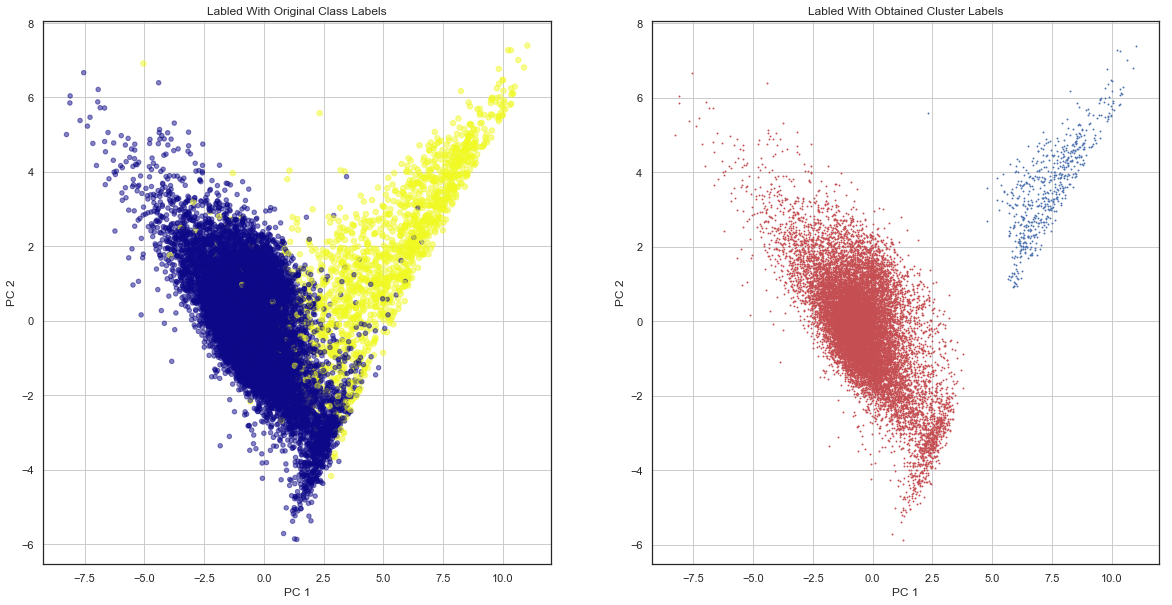

In [59]:
# Plotting 2d Graphs for Initial PCA with class label and PCA after Clustering graphs for visually inspecting
# clustering tendency in the data

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
sns.set(style="white")
ax[0].scatter(x = df_pca[pca_weight_strings[0]], y = df_pca[pca_weight_strings[1]] , \
            c = df_pca["class"], cmap ="plasma", s = (df_pca["class"] + 2)*10, alpha = 0.5)

ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")
ax[0].set_title("Labled With Original Class Labels")
ax[0].grid()

#ax[1].scatter(x = Y_PCAGMM[: , 0], y = Y_PCAGMM[: , 1] , \
#            c = (1- n_components) , cmap ="plasma", s = ((1- n_components) + 2)*10, alpha = 0.5))

for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    ax[1].scatter(X[Y_PCA3GMM == i, 0], X[Y_PCA3GMM == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


ax[1].set_xlabel("PC 1")
ax[1].set_ylabel("PC 2")
ax[1].set_title("Labled With Obtained Cluster Labels")

ax[1].grid()